In [1]:
import math
import numpy
import keras
from keras.models import Sequential
from keras.layers import Activation, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.regularizers import l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from vis.visualization import visualize_cam, visualize_saliency, visualize_activation
from vis.utils import utils
import itertools
import os

Using TensorFlow backend.


In [2]:
root_path = r"c:\Data\labels-RandomSplit"

train_path = os.path.join(root_path, "train")
valid_path = os.path.join(root_path, "valid")
test_path = os.path.join(root_path, "test")

In [3]:
image_size = 64
image_height = 364
image_width = 99
train_batch_size = 75

train_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_path,
    target_size=(image_height, image_width),
    color_mode='grayscale',
    classes=["pos", "neg"],
    shuffle=True,
    batch_size=train_batch_size)

valid_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
    valid_path,
    target_size=(image_height, image_width),
    color_mode='grayscale',
    classes=["pos", "neg"],
    shuffle=True,
    batch_size=train_batch_size)

test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path,
    target_size=(image_height, image_width),
    color_mode='grayscale',
    classes=["pos", "neg"],
    shuffle=True)

test_batches.batch_size = test_batches.n
x_test, y_test = next(test_batches)
print("x_test.shape: {}".format(x_test.shape))
print("y_test.shape: {}".format(y_test.shape))

Found 2816 images belonging to 2 classes.
Found 469 images belonging to 2 classes.
Found 1409 images belonging to 2 classes.
x_test.shape: (1409, 364, 99, 1)
y_test.shape: (1409, 2)


In [4]:
def plots(ims, figsize=(20,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i][:, :, 0], cmap='gray')

def cplots(ims, figsize=(20,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis("Off")
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i][:, :])

In [5]:
# imgs, labels = next(train_batches)
# plots(imgs[:10], titles=labels[:10])

In [6]:
weight_decay = 0.0001


model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(image_height, image_width, 1)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.25))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.25))

model.add(Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(weight_decay)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(.25))

model.add(GlobalAveragePooling2D())

# model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))
#model.add(Dense(2, activation='softmax'))


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 364, 99, 32)       320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 364, 99, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 182, 49, 64)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 182, 49, 64)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 182, 49, 128)      73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 182, 49, 128)      147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 91, 24, 128)       0         
__________

In [8]:
model.compile(Adam(lr=.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit_generator(
    train_batches,
    steps_per_epoch=train_batches.n // train_batch_size,
    validation_data=valid_batches,
    validation_steps=valid_batches.n // train_batch_size,
    epochs=25,
    verbose=1)

Epoch 1/25
37/37 [==============================] - 48s 1s/step - loss: 0.7274 - acc: 0.6032 - val_loss: 0.6959 - val_acc: 0.6200
Epoch 2/25
37/37 [==============================] - 40s 1s/step - loss: 0.6936 - acc: 0.6087 - val_loss: 0.6838 - val_acc: 0.6142
Epoch 3/25
37/37 [==============================] - 37s 987ms/step - loss: 0.6882 - acc: 0.6017 - val_loss: 0.6812 - val_acc: 0.6091
Epoch 4/25
37/37 [==============================] - 36s 985ms/step - loss: 0.6781 - acc: 0.6133 - val_loss: 0.6799 - val_acc: 0.6269
Epoch 5/25
37/37 [==============================] - 37s 987ms/step - loss: 0.6826 - acc: 0.6010 - val_loss: 0.6707 - val_acc: 0.6168
Epoch 6/25
37/37 [==============================] - 37s 987ms/step - loss: 0.6771 - acc: 0.6016 - val_loss: 0.6703 - val_acc: 0.5939
Epoch 7/25
37/37 [==============================] - 36s 982ms/step - loss: 0.6415 - acc: 0.6076 - val_loss: 0.6138 - val_acc: 0.6168
Epoch 8/25
37/37 [==============================] - 37s 987ms/step - loss: 

Text(0.5,1,'Accuracy Curves')

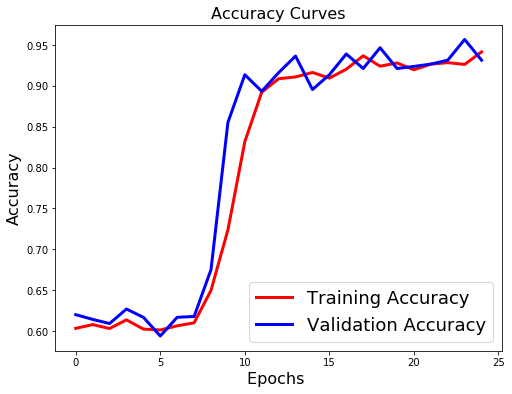

In [10]:
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [11]:
score = model.evaluate(x_test, y_test, verbose=0)
score[1]

0.9396735273243435

In [12]:
y_pred = model.predict_classes(x_test)
acc = sum([y_test[i,1]==y_pred[i] for i in range(test_batches.n)]) / test_batches.n
print("Accuracy = {:.2f}%".format(acc*100))

Accuracy = 93.97%


[0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0]
[0 1 0 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0]


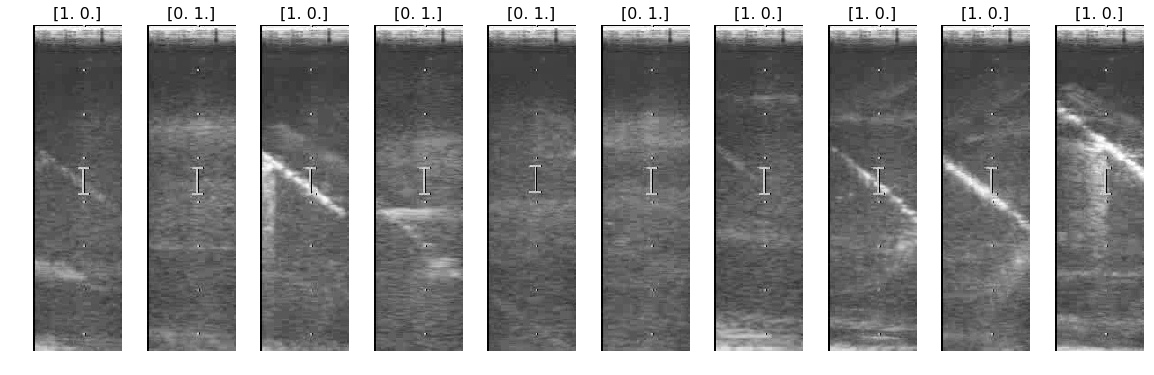

In [13]:
print(y_test[:30,1].astype(int))
print(y_pred[:30])
plots(x_test[:10], titles=y_test[:10])

In [14]:
import pandas as pd
y_t = pd.Series(y_test[:,1])
y_p = pd.Series(y_pred)
pd.crosstab(y_t, y_p, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0.0,789,66,855
1.0,19,535,554
All,808,601,1409


In [15]:
len(model.layers)

16

(10, 364, 99)
Min value of all heatmaps = 0
Max value of all heatmaps = 1
Values in all heatmaps = 1
Min value of all heatmaps = 0
Max value of all heatmaps = 1
Values in all heatmaps = 1
Min value of all heatmaps = 0
Max value of all heatmaps = 1
Values in all heatmaps = 1
Min value of all heatmaps = 0
Max value of all heatmaps = 1
Values in all heatmaps = 1
Min value of all heatmaps = 0
Max value of all heatmaps = 1
Values in all heatmaps = 1
Min value of all heatmaps = 0
Max value of all heatmaps = 1
Values in all heatmaps = 1
Min value of all heatmaps = 0
Max value of all heatmaps = 1
Values in all heatmaps = 1
Min value of all heatmaps = 0
Max value of all heatmaps = 1
Values in all heatmaps = 1
Min value of all heatmaps = 0
Max value of all heatmaps = 1
Values in all heatmaps = 1
Min value of all heatmaps = 0
Max value of all heatmaps = 1
Values in all heatmaps = 1


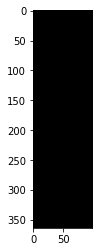

In [16]:
n_images = 10
start_index = 500
heat_map = numpy.zeros((n_images, image_height, image_width), dtype=int)
print(heat_map.shape)

for i in range(n_images):
    heat_map[i][:,:] = visualize_cam(model, 12, None, x_test[start_index + i])
    print("Min value of all heatmaps = {}".format(numpy.min(heat_map[i])))
    print("Max value of all heatmaps = {}".format(numpy.max(heat_map[i])))
    print("Values in all heatmaps = {}".format(numpy.count_nonzero(heat_map[i])))
    plt.imshow(heat_map[i], cmap='gray')

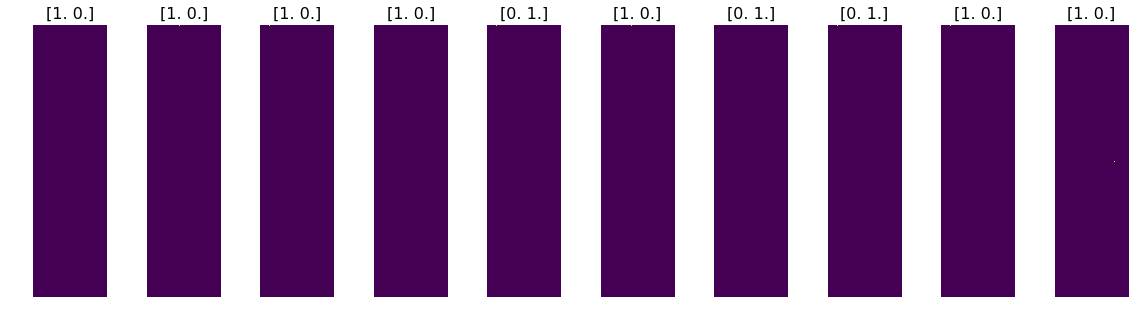

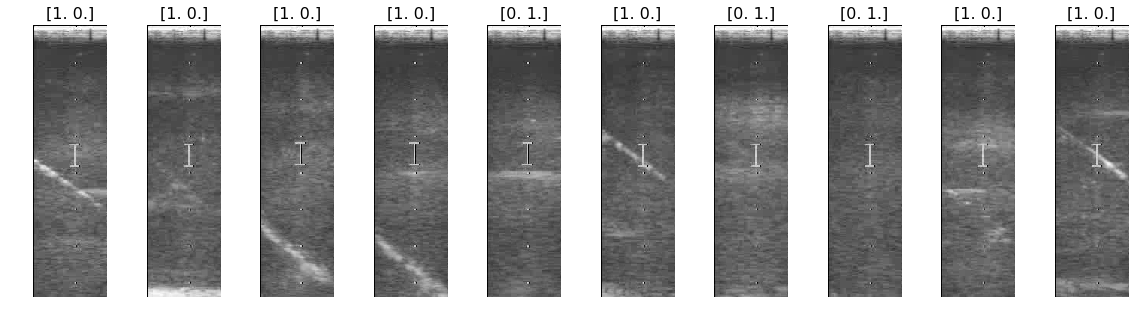

In [17]:
cplots(heat_map[:n_images],
       figsize=(20,5),
       rows=1,
       titles=y_test[start_index:(start_index + n_images)])

plots(x_test[start_index:(start_index + n_images)],
      figsize=(20,5),
      rows=1,
      titles=y_test[start_index:(start_index + n_images)])